<a href="https://colab.research.google.com/github/yasamankfd/2-functions-With-Thread/blob/master/hematoma_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive/


Text(0.5, 1.0, 'img 2')

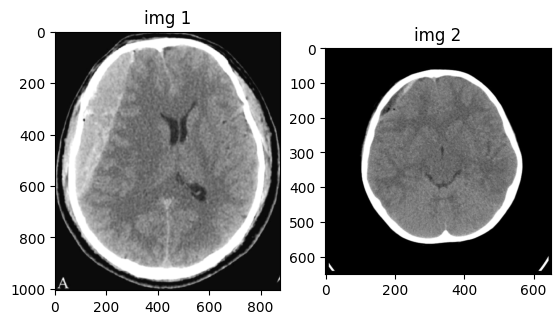

In [ ]:
import math
from scipy import fftpack
import os,sys
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
from google.colab import drive
drive.mount("/content/drive/")
os.chdir("/content/drive/My Drive/image proccessing photos/brain ct/")

img1 = cv2.imread("hematoma_12.png",cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("hematoma_11.jpg",cv2.IMREAD_GRAYSCALE)

h1,w2 = img1.shape
h1,w2 = img2.shape

plt.subplot(1,2,1)
plt.imshow(img1,cmap="gray")
plt.title("img 1")

plt.subplot(1,2,2)
plt.imshow(img2,cmap='gray')
plt.title('img 2')



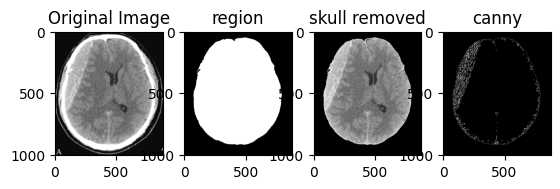

In [ ]:
def remove_skull_noise(original_image):
    # brain_region_image = region_growing2(original_image,seed_point)
    brain_region_image = region_growing(original_image)

    # Perform AND operation to remove skull noise (Step 2)
    skull_removed_image = cv2.bitwise_and(original_image, original_image, mask=brain_region_image)
    return brain_region_image , skull_removed_image

def find_seed_points(image, target_value):
    seed_points = []
    h,w = image.shape

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (( ((h/2 -10) <= x <= (h/2 + 10)) and ((w/2 -10) <= y <= (w/2 + 10)) )):#((target_value - 5) <= image[x, y] <= (target_value + 5)) and
                seed_points.append((x, y))

    return seed_points


def region_growing(image):
    seeds = find_seed_points(image,130)
    threshold = 120
    height, width = image.shape[:2]
    segmented = np.full(image.shape, 0, dtype=np.uint8)
    visited = np.zeros_like(image)

    for seed in seeds:
        stack = [seed]

        while stack:
            current_point = stack.pop()
            x, y = current_point

            if 0 <= x < height and 0 <= y < width and not visited[x, y]:
                if abs(int(image[x, y]) - int(image[seed])) < threshold:
                    segmented[x, y] = 255
                    visited[x, y] = 1
                    stack += [
                        (x + 1, y),
                        (x - 1, y),
                        (x, y + 1),
                        (x, y - 1),
                        (x + 1, y + 1),
                        (x - 1, y - 1),
                        (x + 1, y - 1),
                        (x - 1, y + 1),
                    ]

    return segmented

def edge_detection_improved_canny(image, threshold=120, min_value=50):
    # Step 1: Apply Gaussian smoothing filter
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)

    # Step 2: Calculate gradient amplitude and direction
    sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx)

    # Step 3: Non-maximum suppression
    dx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    gradient_direction = np.arctan2(dy, dx) * (180 / np.pi)
    gradient_direction[gradient_direction < 0] += 180

    non_max_suppression = np.zeros_like(blurred_image)

    for i in range(1, blurred_image.shape[0] - 1):
        for j in range(1, blurred_image.shape[1] - 1):
            orientation = gradient_direction[i, j]

            q = 255
            r = 255

            if (0 <= orientation < 22.5) or (157.5 <= orientation <= 180):
                q = blurred_image[i, j + 1]
                r = blurred_image[i, j - 1]
            elif 22.5 <= orientation < 67.5:
                q = blurred_image[i + 1, j - 1]
                r = blurred_image[i - 1, j + 1]
            elif 67.5 <= orientation < 112.5:
                q = blurred_image[i + 1, j]
                r = blurred_image[i - 1, j]
            elif 112.5 <= orientation < 157.5:
                q = blurred_image[i - 1, j - 1]
                r = blurred_image[i + 1, j + 1]

            if blurred_image[i, j] >= q and blurred_image[i, j] >= r:
                non_max_suppression[i, j] = blurred_image[i, j]
            else:
                non_max_suppression[i, j] = 0

    # Step 4: Thresholding
    edge_image = np.zeros_like(blurred_image)
    edge_image[non_max_suppression > threshold] = 1

    return edge_image



# original_image = cv2.imread("15.jpg",cv2.IMREAD_GRAYSCALE)
original_image =  cv2.imread("hematoma_12.png",cv2.IMREAD_GRAYSCALE)
region , skull_removed_image = remove_skull_noise(original_image)

# Step 1: Improved Canny Edge Detection
edge_image = edge_detection_improved_canny(skull_removed_image, threshold=170, min_value=50)

inverted_hematoma_image = cv2.bitwise_not(edge_image)

# Visualization
plt.subplot(1, 4, 1)
plt.imshow(original_image.astype(np.float16), cmap="gray")
plt.title("Original Image")

plt.subplot(1, 4, 2)
plt.imshow(region, cmap="gray")
plt.title("region")

plt.subplot(1, 4, 3)
plt.imshow(skull_removed_image, cmap="gray")
plt.title("skull removed")

plt.subplot(1, 4, 4)
plt.imshow(edge_image, cmap="gray")
plt.title("canny")

plt.show()


Text(0.5, 1.0, 'noise eliminated')

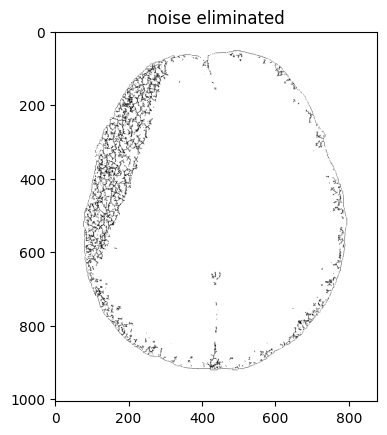

In [ ]:
plt.imshow(inverted_hematoma_image, cmap="gray")
plt.title("noise eliminated")

Text(0.5, 1.0, 'noise eliminated')

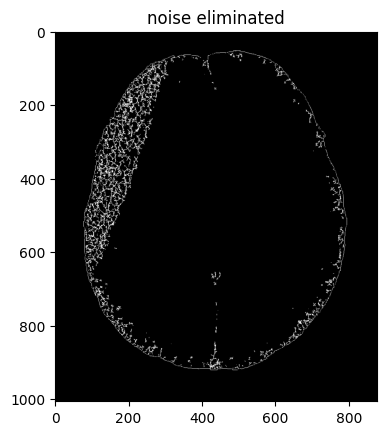

In [ ]:
plt.imshow(edge_image, cmap="gray")
plt.title("noise eliminated")

Text(0.5, 1.0, 'noise eliminated')

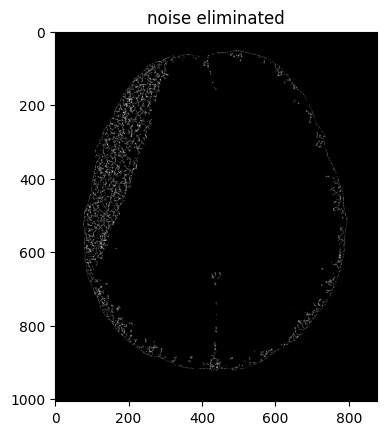

In [ ]:
result_image = cv2.bitwise_and(cv2.bitwise_not(inverted_hematoma_image), skull_removed_image)
plt.imshow(result_image, cmap="gray")
plt.title("noise eliminated")

In [ ]:
def dice_coefficient(seg_image, ground_truth):
  x , y = seg_image.shape
  intersection = 0
  total_pixels_seg = np.sum(seg_image)
  total_pixels_gt = np.sum(ground_truth)
  print(total_pixels_gt)

  for i in range(x):
    for j in range(y):

      if((seg_image[i,j] > 0) & (ground_truth[i,j] > 0)):
        intersection +=1


  dice = (intersection) / (total_pixels_seg)

  return dice

# Assuming you have a ground truth binary image named ground_truth
# Make sure ground_truth has the same dimensions as edge_image
ground_truth = cv2.imread("15_Seg.jpg", cv2.IMREAD_GRAYSCALE)

dice_score = dice_coefficient(edge_image, ground_truth)
print(f'Dice Coefficient: {dice_score:.10f}')

1639222


IndexError: index 650 is out of bounds for axis 1 with size 650